<a href="https://colab.research.google.com/github/dahlia52/Advanced-Statistical-Data-Analysis/blob/main/seq_classification_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10, CIFAR100
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path = './datasets/'

transform = transforms.Compose([transforms.ToTensor()]) # 이미지를 텐서로 변환

# Prepare Data
train_data = MNIST(root = path, train = True, transform = transform, download = True)
test_data = MNIST(root = path, train = False, transform = transform, download = True)

batch_size = 100

# DataLoader
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, num_workers = 4)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False, num_workers = 4)

print(train_data)
print(test_data)

100%|██████████| 9912422/9912422 [00:00<00:00, 56072763.53it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101709230.75it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39660571.04it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18695317.73it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps:0")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu:0")

print(device)

cuda:0


In [ ]:
_, seq_len, input_size = train_data[0][0].shape # (1,28,28)
output_shape = len(train_data.classes) # 10
hidden_size = input_size * 2

# layer 설정
num_layers = 4
batch_first = True
bidirectional = True

model_name = "rnn"

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

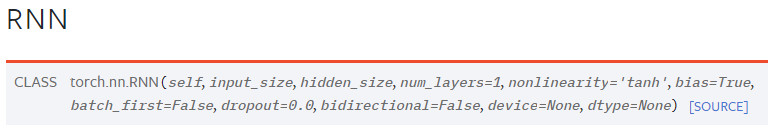

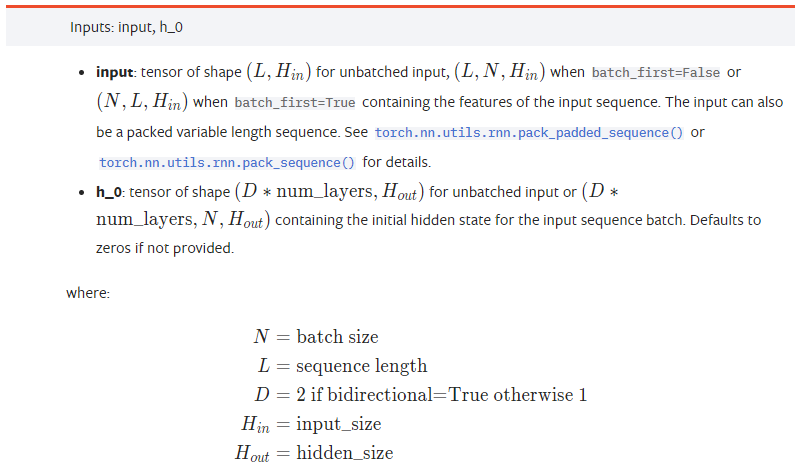

- RNN module : 여러 layer, 양방향 layer를 편하게 쌓도록 구현됨.

  - batch_first = True : ($N, L, H_{in}$)
  - batch_first = False: ($L, N, H_{in}$)


- 데이터가 순차적으로 입력되고 다음 단어가 무엇인지 알 수 없을 때는 bidirectional = False 로 설정해야 함.

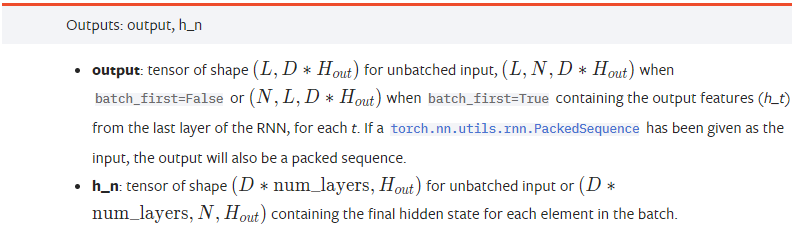

- output : 각 time step에서의 출력. 최상단의 hidden layer

- h_n : 마지막 time step에서의 hidden state. sequence data에 대한 최종 요약 (결론)

In [ ]:
class RNNClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers = 1, batch_first = True, bidirectional = False):
    super().__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_first = batch_first
    self.bidirectional = bidirectional

    if self.bidirectional:
      self.direction = 2 # 양방향이면 x2
    else:
      self.direction = 1

    self.seq = nn.RNN(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers,
                      batch_first = self.batch_first, bidirectional = self.bidirectional)
    self.fc = nn.Linear(self.hidden_size * self.direction, output_shape)

  def forward(self, x):
    x = x.reshape(-1, seq_len, self.input_size)
    h0 = torch.zeros(self.direction*self.num_layers, batch_size, self.hidden_size) # h_0: (D*num_layers, N, H_out)
    out, hidden = self.seq(x, h0.detach().to(device)) # detach(): gradient 계산에서 분리 # h_0을 설정하지 않아도 알아서 pytorch에서 자동으로 zero로 설정해줌.
    # neural network : graph structure, computation -> computational graph (direction)
    # h_0은 backpropagation으로 update할 값이 아니므로 detach() 적용
    out = out[:, -1, :].squeeze() # out.shape: (N,L,D*H_out) # 마지막 time step의 마지막 hidden value만 가져옴 # squeeze(): 불필요한 1차원을 줄여줌. (N,1,D*H_out) -> (N, D*H_out)
    out = self.fc(out)

    return out

In [ ]:
class LSTMClassifier(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers = 1, batch_first = True, bidirectional = True):
    super().__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_first = batch_first
    self.bidirectional = bidirectional

    if self.bidirectional:
      self.direction = 2
    else:
      self.direction = 1

    self.seq = nn.LSTMM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers,
                        batch_first = self.batch_first, bidirectional = self.bidirectional)
    self.fc = nn.Linear(self.hidden_size*self.direction, output_shape)

  def forward(self, x):
    x = x.reshape(-1, seq_len, self.input_size)
    h0 = torch.zeros(self.direction*self.num_layers, batch_size, self.hidden_size)
    c0 = torch.zeros(self.direction * self.num_layers, batch_size, self.hidden_size)

    out, (hidden, cell) = self.seq(x, (h0.detach().to(device), c0.detach().to(device))) # h0과 c0을 튜플로 넣어줌
    out = out[:,-1,:].squeeze()
    out = self.fc(out)

    return out

In [ ]:
class GRUClassifier(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers = 1, batch_first = True, bidirectional = True):
    super().__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_first = batch_first
    self.bidirectional = bidirectional

    if self.bidirectional:
      self.direction = 2
    else:
      self.direction = 1

    self.seq = nn.GRU(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers,
                        batch_first = self.batch_first, bidirectional = self.bidirectional)
    self.fc = nn.Linear(self.hidden_size*self.direction, output_shape)

  def forward(self, x):
    x = x.reshape(-1, seq_len, self.input_size)
    h0 = torch.zeros(self.direction*self.num_layers, batch_size, self.hidden_size)

    out, (hidden, cell) = self.seq(x, h0.detach().to(device)) # h0과 c0을 튜플로 넣어줌
    out = out[:,-1,:].squeeze()
    out = self.fc(out)

    return out

In [ ]:
device = torch.device("cuda:0")

if model_name == "rnn":
  classifier = RNNClassifier
elif model_name == "lstm":
  classifier = LSTMClassifier
elif model_name == "gru":
  classifier = GRUClassifier

In [ ]:
model = classifier(input_size, hidden_size, num_layers, batch_first, bidirectional).to(device)
loss = nn.CrossEntropyLoss(reduction = 'sum')

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
model

RNNClassifier(
  (seq): RNN(28, 56, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=112, out_features=10, bias=True)
)

In [ ]:
num_epoch = 50
train_loss_list, test_loss_list = list(), list()

for i in range(num_epoch):
  # train
  model.train()
  total_loss = 0
  count = 0

  for batch_idx, (x, y) in enumerate(train_loader):
    x, y = x.to(device), y.to(device)

    y_est = model.forward(x)
    cost = loss(y_est, y)

    total_loss += cost.item()

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pred = torch.argmax(y_est, dim = -1)
    count += (pred == y).sum().item()

  acc = count / len(train_data)
  ave_loss = total_loss / len(train_data)
  train_loss_list.append(ave_loss)

  if i % 1 == 0:
    print("\nEpoch %d Train: Loss %.3f / Accuracy %.3f"%(i,ave_loss,acc))


  # test
  model.eval()

  total_loss = 0
  count = 0

  with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
      x, y = x.to(device), y.to(device)
      y_est = model.forward(x)
      cost = loss(y_est, y)

      total_loss += cost.item()

      pred = torch.argmax(y_est, dim = -1)
      count += (pred == y).sum().item()

    acc = count / len(test_data)
    avg_loss = total_loss / len(test_data)

    test_loss_list.append(avg_loss)

    if i % 1 == 0:
      print("Epoch %d Test: Loss %.3f / Accuracy %.3f"%(i,avg_loss,acc))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 0 Train: Loss 0.715 / Accuracy 0.755
Epoch 0 Test: Loss 0.299 / Accuracy 0.913

Epoch 1 Train: Loss 0.258 / Accuracy 0.925
Epoch 1 Test: Loss 0.234 / Accuracy 0.933

Epoch 2 Train: Loss 0.193 / Accuracy 0.944
Epoch 2 Test: Loss 0.169 / Accuracy 0.953

Epoch 3 Train: Loss 0.163 / Accuracy 0.953
Epoch 3 Test: Loss 0.149 / Accuracy 0.958

Epoch 4 Train: Loss 0.139 / Accuracy 0.960
Epoch 4 Test: Loss 0.120 / Accuracy 0.966

Epoch 5 Train: Loss 0.124 / Accuracy 0.965
Epoch 5 Test: Loss 0.113 / Accuracy 0.968

Epoch 6 Train: Loss 0.114 / Accuracy 0.969
Epoch 6 Test: Loss 0.123 / Accuracy 0.966

Epoch 7 Train: Loss 0.106 / Accuracy 0.970
Epoch 7 Test: Loss 0.108 / Accuracy 0.970

Epoch 8 Train: Loss 0.101 / Accuracy 0.971
Epoch 8 Test: Loss 0.100 / Accuracy 0.974

Epoch 9 Train: Loss 0.103 / Accuracy 0.970
Epoch 9 Test: Loss 0.112 / Accuracy 0.970

Epoch 10 Train: Loss 0.093 / Accuracy 0.973
Epoch 10 Test: Loss 0.098 / Accuracy 0.972

Epoch 11 Train: Loss 0.083 / Accuracy 0.977
Epoch 1

In [ ]:
num_parameter = 0
for parameter in model.parameters():
  print(parameter.shape)
  num_parameter += np.prod(parameter.size())
print(num_parameter)

torch.Size([56, 28])
torch.Size([56, 56])
torch.Size([56])
torch.Size([56])
torch.Size([56, 28])
torch.Size([56, 56])
torch.Size([56])
torch.Size([56])
torch.Size([56, 112])
torch.Size([56, 56])
torch.Size([56])
torch.Size([56])
torch.Size([56, 112])
torch.Size([56, 56])
torch.Size([56])
torch.Size([56])
torch.Size([56, 112])
torch.Size([56, 56])
torch.Size([56])
torch.Size([56])
torch.Size([56, 112])
torch.Size([56, 56])
torch.Size([56])
torch.Size([56])
torch.Size([56, 112])
torch.Size([56, 56])
torch.Size([56])
torch.Size([56])
torch.Size([56, 112])
torch.Size([56, 56])
torch.Size([56])
torch.Size([56])
torch.Size([10, 112])
torch.Size([10])
67882


- sequence length가 다른 경우를 위해 rnn.pack_padded_sequence() 기능이 존재